# 1D CNN for EOG Eye Tracking

This notebook trains a 1D CNN to classify eye movements from EOG signal data.

## Preprocessing

First, preprocess the data using the `preprocess_for_cnn.py` script:

```python
from preprocess_for_cnn import preprocess_for_cnn
from pathlib import Path

signal_path = Path("data/caden/processed/opensignals_84_BA_20_AE_BF_DA_2025-11-17T10-45-58.txt")
label_path = Path("data/caden/processed/keypress_labels_edited_2025-11-17T10-45-58.txt")

X, y, stats = preprocess_for_cnn(signal_path, label_path)
```

The preprocessed data is saved as:
- `preprocessed_cnn_data.npz` - Complete dataset with metadata
- `preprocessed_cnn_data.X.npy` - Feature array (n_segments, window_length, n_channels)
- `preprocessed_cnn_data.y.npy` - Label array (n_segments,)


In [1]:
# Run preprocessing
from preprocess_for_cnn import preprocess_for_cnn
from pathlib import Path

signal_path = Path("data/caden/processed/opensignals_84_BA_20_AE_BF_DA_2025-11-17T10-45-58.txt")
label_path = Path("data/caden/processed/keypress_labels_edited_2025-11-17T10-45-58.txt")

X, y, stats = preprocess_for_cnn(signal_path, label_path)

print(f"\nPreprocessed data ready!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {sorted(set(y))}")


Preprocessing EOG Data for 1D CNN

[1/6] Loading data...
  Signal samples: 78501
  Signal channels: 11
  Label samples: 78436

[2/6] Aligning timestamps...
Label start timestamp: 1763343173625.000 ms
Signal start timestamp: 1763343173625.000 ms
Time offset: 0.000 ms (0.000 seconds)

[3/6] Creating segments...
  Total segments: 95

[4/6] Analyzing distribution...

  Segment Distribution:
  --------------------------------------------------
  blink     :     5 segments, median length:   551 samples
  down      :     6 segments, median length:   850 samples
  left      :    18 segments, median length:   921 samples
  right     :    18 segments, median length:   920 samples
  stare     :    42 segments, median length:   590 samples
  up        :     6 segments, median length:   847 samples

  Overall median segment length: 811 samples

[5/6] Normalizing segment lengths...
  Using median length as window size: 811 samples
  Using 11 signal channels: [0, 1, 2, 3, 4]...
  Final shape: X=(95, 

## Load Preprocessed Data

Load the preprocessed data and prepare it for training.

In [2]:
# Load preprocessed data
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data
data_path = Path("data/caden/processed/preprocessed_cnn_data.npz")
data = np.load(data_path, allow_pickle=True)

X = data["X"]  # Shape: (n_segments, window_length, n_channels)
y = data["y"]  # Shape: (n_segments,)

print(f"Loaded data:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Classes: {np.unique(y)}")

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nEncoded labels:")
print(f"  y_encoded shape: {y_encoded.shape}")
print(f"  Unique classes: {np.unique(y_encoded)}")
print(f"  Class mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# Split into train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTrain/Validation Split:")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Train class distribution: {np.bincount(y_train)}")
print(f"  Val class distribution: {np.bincount(y_val)}")


Loaded data:
  X shape: (95, 811, 11)
  y shape: (95,)
  Classes: ['blink' 'down' 'left' 'right' 'stare' 'up']

Encoded labels:
  y_encoded shape: (95,)
  Unique classes: [0 1 2 3 4 5]
  Class mapping: {np.str_('blink'): 0, np.str_('down'): 1, np.str_('left'): 2, np.str_('right'): 3, np.str_('stare'): 4, np.str_('up'): 5}

Train/Validation Split:
  Train: 76 samples
  Validation: 19 samples
  Train class distribution: [ 4  5 14 14 34  5]
  Val class distribution: [1 1 4 4 8 1]


## Create 1D CNN Model

Define a 1D CNN architecture suitable for time series classification.

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set device - prioritize MPS (Apple Silicon), then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Define 1D CNN model
class CNN1D(nn.Module):
    def __init__(self, input_channels, num_classes, window_length):
        super(CNN1D, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate flattened size after convolutions
        # After 3 pooling operations with kernel_size=2, sequence length is divided by 8
        flattened_size = (window_length // 8) * 256
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # x shape: (batch, channels, sequence_length)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Create model
n_channels = X.shape[2]
window_length = X.shape[1]
n_classes = len(np.unique(y_encoded))

model = CNN1D(input_channels=n_channels, num_classes=n_classes, window_length=window_length)
model = model.to(device)

print(f"Model created:")
print(f"  Input channels: {n_channels}")
print(f"  Window length: {window_length}")
print(f"  Number of classes: {n_classes}")
print(f"\nModel architecture:")
print(model)


Using device: mps
Model created:
  Input channels: 11
  Window length: 811
  Number of classes: 6

Model architecture:
CNN1D(
  (conv1): Conv1d(11, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25856, out_features=128, bias=True)
  (relu4): Re

## Training Setup

Define loss function, optimizer, and training loop.


In [69]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training parameters
num_epochs = 100

print(f"Training setup:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Epochs: {num_epochs}")


Training setup:
  Loss function: CrossEntropyLoss
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau
  Epochs: 100


In [70]:
# Create Dataset class
class EOGDataset(Dataset):
    def __init__(self, X, y):
        # Convert to float32 and transpose to (batch, channels, sequence_length)
        self.X = torch.FloatTensor(X).transpose(1, 2)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = EOGDataset(X_train, y_train)
val_dataset = EOGDataset(X_val, y_val)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created:")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")


DataLoaders created:
  Batch size: 16
  Train batches: 5
  Validation batches: 2


## Train Model

Train the model and track training/validation metrics.


In [71]:
# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        print()

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
print(f"Training complete! Best validation loss: {best_val_loss:.4f}")


Epoch [1/100]
  Train Loss: 4.3492, Train Acc: 21.05%
  Val Loss: 1.3709, Val Acc: 42.11%

Epoch [5/100]
  Train Loss: 1.1436, Train Acc: 56.58%
  Val Loss: 1.8648, Val Acc: 42.11%

Epoch [10/100]
  Train Loss: 0.7120, Train Acc: 71.05%
  Val Loss: 1.9667, Val Acc: 47.37%

Epoch [15/100]
  Train Loss: 0.5485, Train Acc: 84.21%
  Val Loss: 1.5944, Val Acc: 63.16%

Epoch [20/100]
  Train Loss: 0.3914, Train Acc: 85.53%
  Val Loss: 1.4982, Val Acc: 63.16%

Epoch [25/100]
  Train Loss: 0.3721, Train Acc: 92.11%
  Val Loss: 1.5180, Val Acc: 63.16%

Epoch [30/100]
  Train Loss: 0.3689, Train Acc: 90.79%
  Val Loss: 1.5436, Val Acc: 63.16%

Epoch [35/100]
  Train Loss: 0.3103, Train Acc: 89.47%
  Val Loss: 1.5054, Val Acc: 68.42%

Epoch [40/100]
  Train Loss: 0.3359, Train Acc: 85.53%
  Val Loss: 1.4688, Val Acc: 63.16%

Epoch [45/100]
  Train Loss: 0.3439, Train Acc: 84.21%
  Val Loss: 1.4641, Val Acc: 63.16%

Epoch [50/100]
  Train Loss: 0.3072, Train Acc: 85.53%
  Val Loss: 1.4604, Val Acc

## Visualize Training Progress

Plot training and validation loss/accuracy curves.


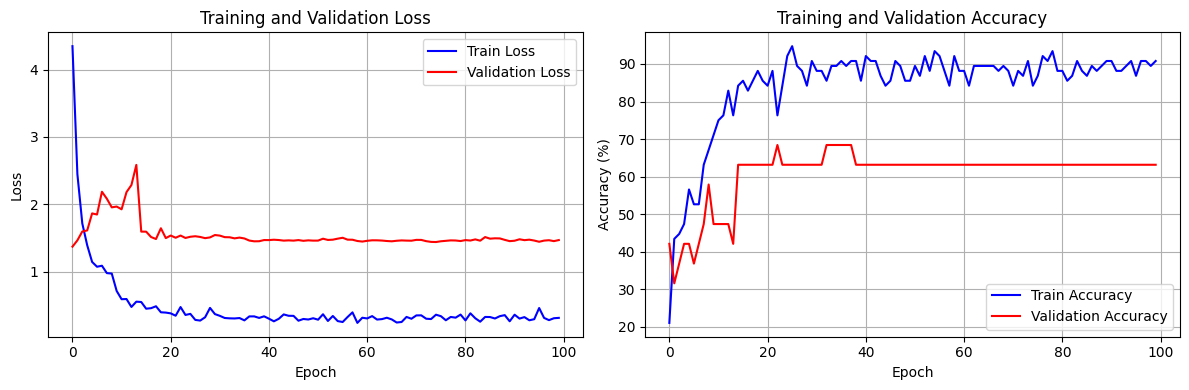

Final Metrics:
  Final Train Loss: 0.3129
  Final Train Accuracy: 90.79%
  Final Val Loss: 1.4684
  Final Val Accuracy: 63.16%


In [72]:
import matplotlib.pyplot as plt

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(train_accuracies, label='Train Accuracy', color='blue')
ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Metrics:")
print(f"  Final Train Loss: {train_losses[-1]:.4f}")
print(f"  Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"  Final Val Loss: {val_losses[-1]:.4f}")
print(f"  Final Val Accuracy: {val_accuracies[-1]:.2f}%")


## Evaluate Model

Get detailed evaluation metrics including confusion matrix and per-class accuracy.


Classification Report:
              precision    recall  f1-score   support

       blink       0.00      0.00      0.00         1
        down       0.00      0.00      0.00         1
        left       0.60      0.75      0.67         4
       right       0.75      0.75      0.75         4
       stare       0.83      0.62      0.71         8
          up       0.00      0.00      0.00         1

    accuracy                           0.58        19
   macro avg       0.36      0.35      0.36        19
weighted avg       0.64      0.58      0.60        19



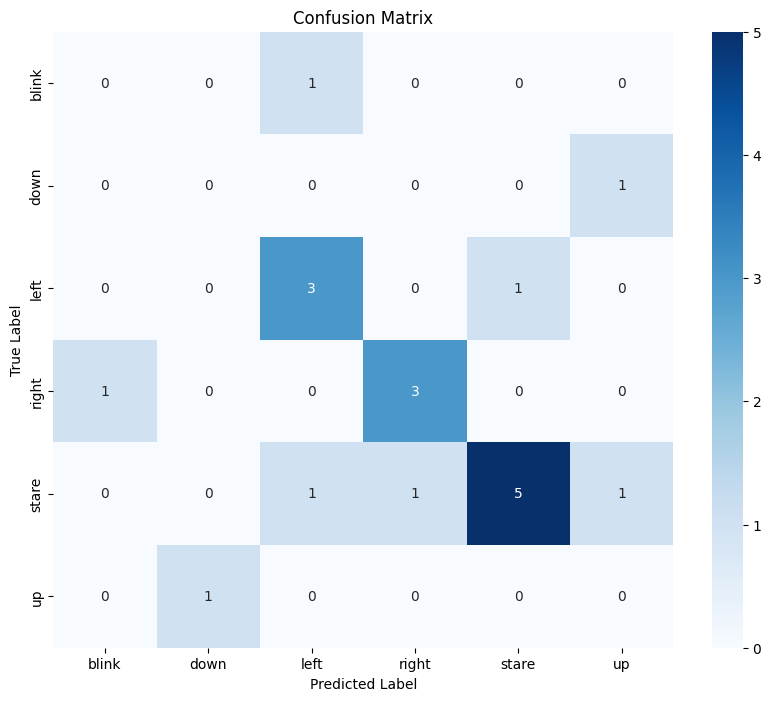


Per-Class Accuracy:
  blink     : 0.00%
  down      : 0.00%
  left      : 75.00%
  right     : 75.00%
  stare     : 62.50%
  up        : 0.00%


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = np.array(all_labels) == i
    if class_mask.sum() > 0:
        class_acc = (np.array(all_preds)[class_mask] == i).sum() / class_mask.sum() * 100
        print(f"  {class_name:10s}: {class_acc:.2f}%")
